In [2]:
%%capture
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
try:
    from imutils import paths
except ImportError:
    !pip install imutils
    from imutils import paths
    
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
# lets start by examining the number of images available in training set
dir_train = "../input/intel-image-classification/seg_train/seg_train/"
for segment in os.listdir(dir_train):
    print("'{}' images in '{}' category".format(
        len(list(paths.list_images(dir_train + segment))),
        segment
    ))
print("Total '{}' images in training set".format(len(list(paths.list_images(dir_train)))))

'2271' images in 'forest' category
'2191' images in 'buildings' category
'2404' images in 'glacier' category
'2382' images in 'street' category
'2512' images in 'mountain' category
'2274' images in 'sea' category
Total '14034' images in training set


So the training set looks failry balanced with similar number of images in each class. Let's pick some random images from each class and try to visualize them

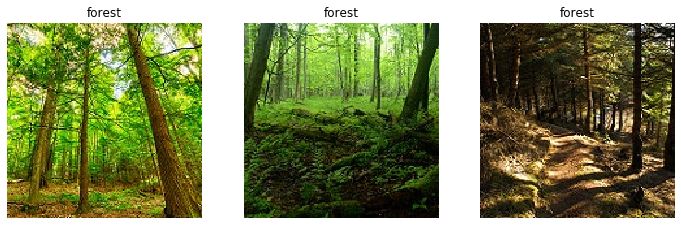

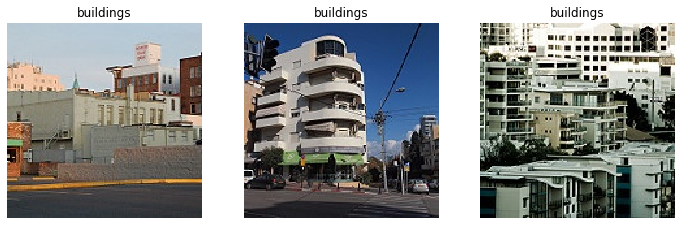

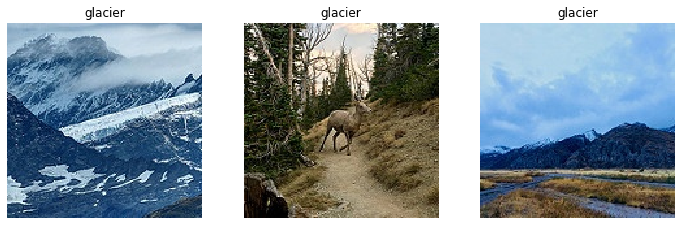

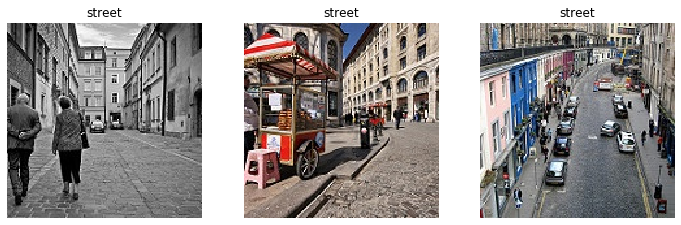

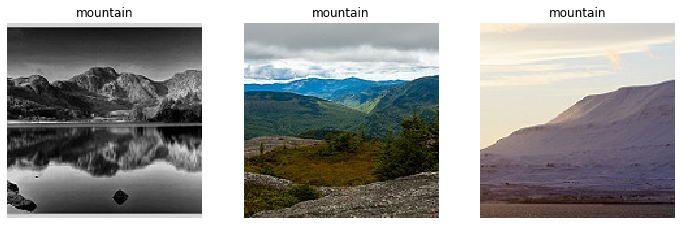

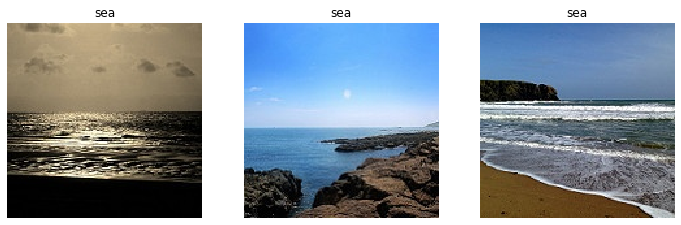

In [135]:
class_list = os.listdir(dir_train)

# number of images to display for each class
columns = 3

# input shape 150x150
shape = (150, 150)

# let's create a dictionary with all the classes and some random images to display
classes = { 
    cls : [
        # read each mage and change the default colorspace
        cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.sample(
            # randomly sample images (length of columns) per class
            list(paths.list_images(dir_train + cls)), columns
        )
    ] for cls in class_list
}

# method to displays images for 'len(classes)' classes 'len(columns)' images per row
def display(classes, columns, cmap=None, figsize=(10, 10)):
    for _class in classes:
        # print(random_images)
        fig, axes = plt.subplots(
            nrows=1, ncols=columns, 
            figsize=figsize, squeeze=False
        )
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                # set map
                if len(img.shape) == 2:
                    cmap = "gray"
                axes[l][m].imshow(img, cmap=cmap)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)

In [160]:
# let us read a random image from a class and examine it for preprocessing
key = random.choice(list(classes.items()))[0]
image = random.sample(list(classes[key]), 1)

Dimensions: (150, 150, 3)


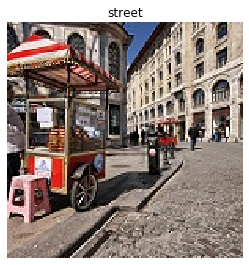

In [161]:
# let's display the image dimension and the image itself
display({key:image}, 1, figsize=(4, 4))
print("Dimensions: " + str(image[0].shape))

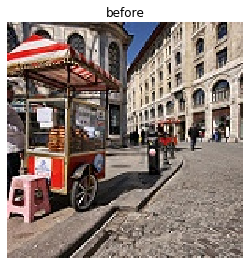

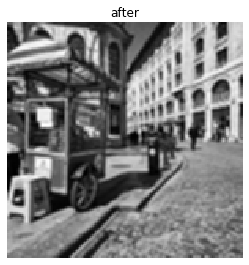

In [162]:
def preprocess(image):
    # copy for later usage?
    img = image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # split
    h,s,v = cv2.split(img)
    # histogram equalization on value 
    v_ = cv2.equalizeHist(v)
    # merge back
    img = cv2.merge([h,s,v_])
    # to rgb
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    # apply gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 1)
    # to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # done
    return img 

img = image[0]
# before after image display
display({"before": [img], "after": [preprocess(img)]}, 1, figsize=(4,4))

#### Let's start preparing for the training 

In this section let us create our generators an image augumentors required for our training

In [176]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# seed constant for reproducable results
SEED = 255
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.set_random_seed(SEED)

# bunch of other stuff
from keras import backend as K
tf_config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=tf_config)
K.set_session(sess)

IM_WIDTH = 150
IM_HEIGHT = 150
BATCH_SIZE = 32

# generator for training
_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.01,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=2.99,
    preprocessing_function=preprocess
)

_train = _generator.flow_from_directory(
    directory="../input/intel-image-classification/seg_train/seg_train/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=SEED,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE
    
)

# generator for validation and test sets
_test_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess
)
# validation set
_valid = _generator.flow_from_directory(
    directory="../input/intel-image-classification/seg_test/seg_test/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=SEED,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE
)
# test set
_test = _generator.flow_from_directory(
    directory="../input/intel-image-classification/seg_pred/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=SEED,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


### Model Construction

In [168]:
from keras import callbacks
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

In [170]:
class Network(object):

    def __init__(self, height, width, channels, classes, parameter_scaling):
        self.height = height
        self.width = width
        self.channels = channels
        self.output_classes = classes
        self.scale = parameter_scaling

    def model(self):
        # initiate model
        _model = Sequential()
        input_shape = (self.height, self.width, self.channels)
        axis = -1
        # if using theano
        if K.image_data_format() == "channels_first":
            input_shape = (self.channels, self.height, self.width)
            axis = 1

        # conv_1
        _model.add(Conv2D(
            self.scale, (3, 3),
            padding="same",
            input_shape=input_shape)
        )
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # conv_2
        _model.add(Conv2D(self.scale, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # pool_1
        _model.add(MaxPooling2D(pool_size=(2, 2)))
        _model.add(Dropout(0.25))

        # conv_3
        _model.add(Conv2D(self.scale*2, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # conv_4
        _model.add(Conv2D(self.scale*2, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # pool_2
        _model.add(MaxPooling2D(pool_size=(2, 2)))
        _model.add(Dropout(0.25))

        # Fully connected layers
        _model.add(Flatten())
        _model.add(Dense(512))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization())
        _model.add(Dropout(0.5))
        # classifier
        _model.add(Dense(self.output_classes))
        _model.add(Activation("softmax"))

        # return model
        return _model

In [178]:
LR = 1e-4
SCALE = 32
BATCH_SIZE = 32
EPOCHS = 30

def lr_scheduler(epoch, lr):
    if 20 < epoch <= 40:
        return (1e-4)*0.25
    elif 40 < epoch <= 50:
        return 1e-5
    else:
        return lr
    
# define callbacks
_callbacks = [
    callbacks.TensorBoard(
        log_dir="tensorboard", write_graph=True, write_images=False    
    ),
    LearningRateScheduler(lr_scheduler)
]

# initiate model
model = Network(
    height=IM_HEIGHT, width=IM_WIDTH, channels=1, 
    classes=6, parameter_scaling=SCALE
).model()

# compile
model.compile(
    loss="categorical_crossentropy",optimizer=Adam(lr=LR), metrics=["accuracy"]
)
print(_train.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
%%time
# start training
history = model.fit_generator(
    generator=_train,
    steps_per_epoch=_train.samples//BATCH_SIZE,
    validation_data=_valid,
    validation_steps=_valid.samples,
    callbacks=_callbacks,
    epochs=EPOCHS
)

### Testing 

In [ ]:
test_loss, test_acc = model.evaluate_generator(_test, steps=_test.samples, verbose=1)

print('val_loss:', test_loss)
print('val_cat_acc:', test_acc)

In [ ]:
# PREDICT
predictions = model.predict_generator(_test, steps=_test.samples, verbose=1)
# print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = _test.classes

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

In [ ]:
# heatmap
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt="d", 
    cbar = False, 
    cmap = plt.cm.Blues
)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy score
print("Accuracy score of the model: {:.2f}".format(accuracy_score(y_test, y_pred)))

# f1 score
print("F1 score of the model: {:.2f}".format(f1_score(y_test, y_pred)))

# precision
print("Precision score of the model: {:.2f}".format(precision_score(y_test, y_pred)))

# recall
print("Recall score of the model: {:.2f}".format(recall_score(y_test, y_pred)))
